### references

autocorrelation plots: https://www.kaggle.com/jeegarmaru/timeseriesanalysis-autocorrelation

time series analysis: https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series

50 Best ETFs to Invest In for 2018 http://time.com/money/5090801/best-etf-2018/

In [42]:
import ast
import csv
import datetime
import numpy as np
import os
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.svm import SVR
import statistics as stats
from statsmodels.tsa.ar_model import AR
import time

In [43]:
def pandas_output():
    '''
    read csv into pandas df
    '''
    
    print('reading data')
    s = time.time()
    df = pd.read_csv('data.csv')
    print("time to load: {} mins".format((time.time()-s)/60))
    return df

In [44]:
def datetime_converter(item):
    '''
    converts an item inside a pd.Series into datetime obj
    '''
    itemized_date = item.split('-')
    yr = itemized_date[0]
    mth = itemized_date[1]
    day = itemized_date[2]
    
    return datetime.date(int(yr),int(mth),int(day))

In [45]:
data = pandas_output()
data = data.drop(axis=1, columns=['Unnamed: 0'])
data['ratio'] = data['Close']/data['Volume']
data['difference_OC'] = data['Open'] - data['Close']
# data = data.drop(data.index[[1988441]])
data['Date'] = data['Date'].apply(datetime_converter)
data.head()

reading data
time to load: 0.06761900186538697 mins


,etf,Date,Open,High,Low,Close,Volume,ratio,difference_OC
0,aadr,2010-07-21,24.333,24.333,23.946,23.946,43321,0.000553,0.387
1,aadr,2010-07-22,24.644,24.644,24.362,24.487,18031,0.001358,0.157
2,aadr,2010-07-23,24.759,24.759,24.314,24.507,8897,0.002755,0.252
3,aadr,2010-07-26,24.624,24.624,24.449,24.595,19443,0.001265,0.029
4,aadr,2010-07-27,24.477,24.517,24.431,24.517,8456,0.002899,-0.040


In [46]:
def filter_old_data(top_50):
    '''
    filter original dataset so as to only get
    ETFs from 'top 50' list from TIME magazine 
    '''
    new_data = data
    indicies = []
    for i in range(len(new_data)):
        if new_data.loc[i]['etf'] not in top_50:
            indicies.append(i)
    new_data = new_data.drop(indicies)
    print(new_data.head())
    print("new: {}, old: {}".format(len(new_data), len(data)))
    return new_data
    # new_data.to_csv('new_data.csv') # save as csv

In [47]:
%%time
if 'new_data.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    top50raw = ['VOO', 'SCHB', 'IJH', 'IJR', 'IEFA', 'VXUS', 'VSS', 'VWO', 'VNQ', 'BND', 'BSV', 'SCHP', 'VTIP', 'BNDX', 'AOA', 'AOR', 'AOM', 'AOK', 'GAL', 'PRF', 'VTV', 'DLN', 'USMV', 'SPHQ', 'VUG', 'VOE', 'DON', 'VOT', 'VBR', 'DES', 'PRFZ', 'VBK', 'SDY', 'VIGI', 'ICF', 'VNQI', 'IGE', 'PXF', 'EFAV', 'EWX', 'FBND', 'BOND', 'MINT', 'LQD', 'VCSH', 'HYG', 'VTEB', 'SHM', 'PICB', 'EBND']
    top_50 = [i.lower() for i in top50raw]
    new_data_etf_list = list(data['etf'].unique())
    print("The following are not reflected in the dataset:")
    for i in top_50:
        if i not in new_data_etf_list:
            print("  {}".format(i))
    new_data = filter_old_data(top_50)
else:
    new_data = pd.read_csv('new_data.csv', index_col=0)

Wall time: 273 ms


In [48]:
print("{} unique ETFs total".format(len(data.etf.unique())))

1344 unique ETFs total


In [49]:
new_data.head()

,etf,Date,Open,High,Low,Close,Volume,ratio,difference_OC,rolling_avg
51996,aoa,2008-11-25,22.106,22.106,18.985,19.471,10533,0.001849,2.635,19.3256
51997,aoa,2008-11-26,19.332,20.206,19.332,20.189,16239,0.001243,-0.857,19.1598
51998,aoa,2008-11-28,20.023,20.023,20.023,20.023,113,0.177195,0.000,19.0955
51999,aoa,2008-12-01,19.550,19.550,19.072,19.072,2479,0.007693,0.478,19.0080
52000,aoa,2008-12-02,20.372,20.372,18.930,19.573,10385,0.001885,0.799,18.9706


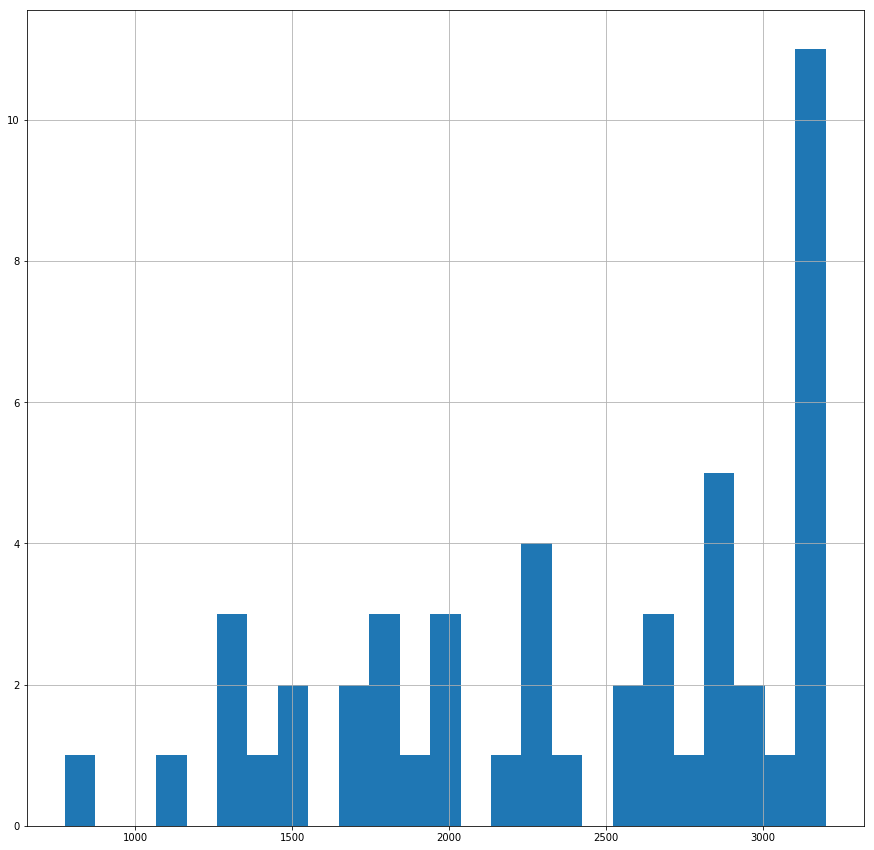

In [50]:
new_data.groupby('etf').count()['Close'].hist(figsize=(15,15), bins = 25)

# Autocorrelations

In [51]:
def read_dict_text(filename):
    '''
    reads the txt files created from autocorrelation_measures()
    and reads the output as a dictionary
    '''
    with open(filename, 'r', encoding='utf-8') as fh:
        autocorr_lags_1 = ast.literal_eval(fh.read())
    return autocorr_lags_1

In [52]:
def ac_dif_lag():
    '''
    combines the autocorrelation_measures() dictionaries together
    '''
    autocorrelation_dif_lags = {}
    for i in range(1,9):
        temp = read_dict_text('output{}.txt'.format(i))
        autocorrelation_dif_lags.update(temp)
    return autocorrelation_dif_lags

In [53]:
def plot_lags(lags_df):
    avg_list = []
    for i in range(30):
        avg_list.append(lags_df.iloc[i].mean())
    plt.figure(figsize=(8,8))
    plt.plot([i+1 for i in range(30)], avg_list, 'bo')

    plt.axvline(x=17, color = 'r') # draw vertical line at 0.95 
    plt.axhline(y=0.95, color = 'r') # draw horizontal line at 17
    plt.title("autocorrelation by lag time")
    plt.xlabel('lag days')
    plt.ylabel('autocorrelation values')
    return

,aadr,aaxj,acim,actx,acwf,acwi,acwv,acwx,adra,adrd,...,yinn,ylco,ymli,ymlp,yxi,yyy,ziv,zmlp,zroz,zsl
1,0.998176,0.996764,0.996746,0.983552,0.994572,0.998861,0.999276,0.996330,0.995772,0.996858,...,0.993108,0.994416,0.996353,0.999583,0.997357,0.996292,0.999118,0.998806,0.998026,0.998364
2,0.996659,0.993801,0.994537,0.966055,0.990175,0.997841,0.998596,0.993072,0.992294,0.994145,...,0.985538,0.988269,0.991745,0.999025,0.994963,0.992548,0.998290,0.997259,0.996132,0.996714
3,0.995299,0.991210,0.992435,0.951907,0.986519,0.996871,0.997940,0.989944,0.989175,0.991763,...,0.978326,0.981232,0.987411,0.998447,0.992438,0.988614,0.997445,0.995742,0.994290,0.995325
4,0.994177,0.988550,0.991003,0.938217,0.982681,0.995935,0.997308,0.986906,0.985896,0.989286,...,0.972196,0.974949,0.983492,0.997880,0.990235,0.984971,0.996643,0.994363,0.992557,0.993618
5,0.993163,0.985868,0.989438,0.927255,0.979676,0.995034,0.996742,0.983901,0.982802,0.986787,...,0.965588,0.968277,0.979736,0.997337,0.988109,0.981343,0.995877,0.993069,0.990856,0.992309


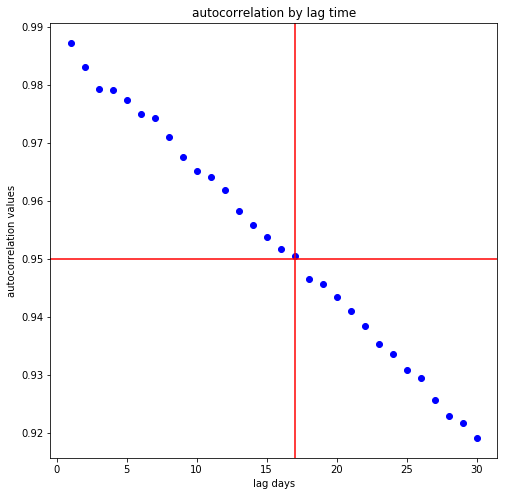

In [54]:
dif_lags = ac_dif_lag()
lags_df = pd.DataFrame()
lags_df = lags_df.from_dict(dif_lags)
lags_df.head()
plot_lags(lags_df)

# Predictions

### DataFrame Preperation

In [55]:
new_data['rolling_avg'] = new_data['Close'].rolling(10).mean()
new_data['rolling_bartlett'] = new_data['Close'].rolling(10, win_type='bartlett').mean()

new_data = new_data.dropna()
print(new_data.head())

top50raw = ['VOO', 'SCHB', 'IJH', 'IJR', 'IEFA', 'VXUS', 'VSS', 'VWO', 'VNQ', 'BND', 'BSV', 'SCHP', 'VTIP', 'BNDX', 'AOA', 'AOR', 'AOM', 'AOK', 'GAL', 'PRF', 'VTV', 'DLN', 'USMV', 'SPHQ', 'VUG', 'VOE', 'DON', 'VOT', 'VBR', 'DES', 'PRFZ', 'VBK', 'SDY', 'VIGI', 'ICF', 'VNQI', 'IGE', 'PXF', 'EFAV', 'EWX', 'FBND', 'BOND', 'MINT', 'LQD', 'VCSH', 'HYG', 'VTEB', 'SHM', 'PICB', 'EBND']
top_50 = [i.lower() for i in top50raw]
top_50_good = [i for i in top_50 if i not in ['vigi', 'vteb']]

       etf        Date    Open    High     Low   Close  Volume     ratio  \
52005  aoa  2008-12-09  20.806  20.848  19.287  20.666   62893  0.000329   
52006  aoa  2008-12-10  20.623  21.151  20.242  20.848   33857  0.000616   
52007  aoa  2008-12-11  22.322  22.322  20.113  20.113    6889  0.002920   
52008  aoa  2008-12-12  19.869  20.372  19.869  20.139   11577  0.001740   
52009  aoa  2008-12-15  20.113  20.113  20.113  20.113     141  0.142645   

       difference_OC  rolling_avg  rolling_bartlett  
52005          0.140      19.7831          19.54685  
52006         -0.225      19.9208          19.60610  
52007          2.209      19.9132          19.78960  
52008         -0.270      19.9248          20.03575  
52009          0.000      20.0289          20.22820  


### Autoregression

In [56]:
def ac_mesasure(new_data, top_50_good, day_lag, preds):
    for etf_name in top_50_good:
        temp_data = new_data[new_data['etf']==etf_name]['Close']        
        if day_lag == 1:
            series = temp_data
            # split dataset
            X = series.values
            train, test = X[1:len(X)-1], X[len(X)-1:]
            # train autoregression
            model = AR(train)
            model_fit = model.fit()
            print('Lag: %s' % model_fit.k_ar)
            # make predictions
            predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
            for i in range(len(predictions)):
                print('predicted=%f, expected=%f' % (predictions[i], test[i]))
            error = mean_squared_error(test, predictions)
            print('Test MSE: %.3f' % error)
            temp = {'etf': etf_name, 'actual_y': test[i], 'predicted_y': predictions[i], 'mae': error}
            preds = preds.append(temp, ignore_index = True)        
        elif day_lag == 7:
            series = temp_data
            # split dataset
            X = series.values
            train, test = X[1:len(X)-7], X[len(X)-7:]
            # train autoregression
            model = AR(train)
            model_fit = model.fit()
            print('Lag: %s' % model_fit.k_ar)
            # make predictions
            predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
            for i in range(len(predictions)):
                print('predicted=%f, expected=%f' % (predictions[i], test[i]))
            error = mean_squared_error(test, predictions)
            print('Test MSE: %.3f' % error)
            temp = {'etf': etf_name, 'actual_y': test[i], 'predicted_y': predictions[i], 'mae': error}
            preds = preds.append(temp, ignore_index = True)

    return preds

In [57]:
if 'preds_autocorr.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds_autocorr = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds_autocorr = ac_mesasure(new_data, top_50_good, 1, preds_autocorr)
    preds_autocorr = preds_autocorr.set_index('etf')
    preds_autocorr['actual_y'] = preds_autocorr['actual_y'].map(float)
    preds_autocorr['predicted_y'] = preds_autocorr['predicted_y'].map(float)
    preds_autocorr.to_csv('preds_autocorr.csv')
else: preds_autocorr = pd.read_csv('preds_autocorr.csv', index_col=0)

if 'preds_autocorr7.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds_autocorr7 = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds_autocorr7 = ac_mesasure(new_data, top_50_good, 7, preds_autocorr7)
    preds_autocorr7 = preds_autocorr7.set_index('etf')
    preds_autocorr7['actual_y'] = preds_autocorr7['actual_y'].map(float)
    preds_autocorr7['predicted_y'] = preds_autocorr7['predicted_y'].map(float)
    preds_autocorr7.to_csv('preds_autocorr7.csv')
else: preds_autocorr7 = pd.read_csv('preds_autocorr7.csv', index_col=0)

### Ridge Regression

In [58]:
def regression_process_ridgeReg(new_data, top_50_good, day_lag, preds):
#     print(etf_name)
    for etf_name in top_50_good:
        temp_data = new_data[new_data['etf']==etf_name]
        if day_lag == 1:
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-1]
            features = []
            for col in [i for i in df_one_day.columns if i not in ['etf','Date','Volume', 'Close', 'difference_OC','ratio']]:
                features.append(col)
            
            y_train = df_one_day['Close'].values
            y_test = df_day['Close'].values
            X_train = np.array(df_one_day[features])
            X_test = np.array(df_day[features])
            
            print("{}\n{}\n{}\n{}".format(y_train.shape, y_test.shape, X_train.shape, X_test.shape))

            # Run SVR and fit to data
            clf = Ridge(alpha=1.0)
            clf.fit(X_train, y_train)

            mae = mean_absolute_error(y_test, clf.predict(X_test))
            print(y_test)
            print("{}\tpredicted".format(clf.predict(X_test)))
            print(mae)
            temp = {'etf': etf_name, 'actual_y': y_test, 'predicted_y': clf.predict(X_test), 'mae': mae}
            preds = preds.append(temp, ignore_index = True)
        if day_lag == 7:
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-5]
            features = []
            for col in [i for i in df_one_day.columns if i not in ['etf','Date','Volume', 'Close', 'difference_OC','ratio']]:
                features.append(col)
            
            y_train = df_one_day['Close'].values
            y_test = df_day['Close'].values
            X_train = np.array(df_one_day[features])
            X_test = np.array(df_day[features])
            
            print("{}".format(X_train))

            # Run SVR and fit to data
            clf = Ridge(alpha=1.0)
            clf.fit(X_train, y_train)

            mae = mean_absolute_error(y_test, clf.predict(X_test))
            print(y_test)
            print("{}\tpredicted".format(clf.predict(X_test)))
            print(mae)
            temp = {'etf': etf_name, 'actual_y': y_test, 'predicted_y': clf.predict(X_test), 'mae': mae}
            preds = preds.append(temp, ignore_index = True)
    return preds

In [59]:
if 'preds_ridgeReg.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds_ridgeReg = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds_ridgeReg = regression_process_ridgeReg(new_data, top_50_good, 1, preds_ridgeReg)
    preds_ridgeReg = preds_ridgeReg.set_index('etf')
    preds_ridgeReg['actual_y'] = preds_ridgeReg['actual_y'].map(float)
    preds_ridgeReg['predicted_y'] = preds_ridgeReg['predicted_y'].map(float)
    preds_ridgeReg.to_csv('preds_ridgeReg.csv')
else: preds_ridgeReg = pd.read_csv('preds_ridgeReg.csv', index_col=0)

if 'preds_ridgeReg7.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds_ridgeReg7 = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds_ridgeReg7 = regression_process_ridgeReg(new_data, top_50_good, 7, preds_ridgeReg7)
    preds_ridgeReg7 = preds_ridgeReg7.set_index('etf')
    preds_ridgeReg7['actual_y'] = preds_ridgeReg7['actual_y'].map(float)
    preds_ridgeReg7['predicted_y'] = preds_ridgeReg7['predicted_y'].map(float)
    preds_ridgeReg7.to_csv('preds_ridgeReg7.csv')
else: preds_ridgeReg7 = pd.read_csv('preds_ridgeReg7.csv', index_col=0)

### Bayesian Ridge Regression

In [60]:
def regression_process_baseline(new_data, top_50_good, day_lag, preds):
#     print(etf_name)
    for etf_name in top_50_good:
        temp_data = new_data[new_data['etf']==etf_name]
        if day_lag == 1:
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-1]
            features = []
            for col in [i for i in df_one_day.columns if i not in ['etf','Date','Volume', 'Close', 'difference_OC','ratio']]:
                features.append(col)
            
            y_train = df_one_day['Close'].values
            y_test = df_day['Close'].values
            X_train = np.array(df_one_day[features])
            X_test = np.array(df_day[features])
            
            print("{}\n{}\n{}\n{}".format(y_train.shape, y_test.shape, X_train.shape, X_test.shape))

            # Run SVR and fit to data
            clf = BayesianRidge(compute_score=True)
            clf.fit(X_train, y_train)

            mae = mean_absolute_error(y_test, clf.predict(X_test))
            print(y_test)
            print("{}\tpredicted".format(clf.predict(X_test)))
            print(mae)
            temp = {'etf': etf_name, 'actual_y': y_test, 'predicted_y': clf.predict(X_test), 'mae': mae}
            preds = preds.append(temp, ignore_index = True)
        if day_lag == 7:
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-5]
            features = []
            for col in [i for i in df_one_day.columns if i not in ['etf','Date','Volume', 'Close', 'difference_OC','ratio']]:
                features.append(col)
            
            y_train = df_one_day['Close'].values
            y_test = df_day['Close'].values
            X_train = np.array(df_one_day[features])
            X_test = np.array(df_day[features])
            
            print("{}".format(X_train))

            # Run SVR and fit to data
            clf = BayesianRidge(compute_score=True)
            clf.fit(X_train, y_train)

            mae = mean_absolute_error(y_test, clf.predict(X_test))
            print(y_test)
            print("{}\tpredicted".format(clf.predict(X_test)))
            print(mae)
            temp = {'etf': etf_name, 'actual_y': y_test, 'predicted_y': clf.predict(X_test), 'mae': mae}
            preds = preds.append(temp, ignore_index = True)
    return preds

In [61]:
if 'preds_base.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds_base = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds_base = regression_process_baseline(new_data, top_50_good, 1, preds_base)
    preds_base = preds_base.set_index('etf')
    preds_base['actual_y'] = preds_base['actual_y'].map(float)
    preds_base['predicted_y'] = preds_base['predicted_y'].map(float)
    preds_base.to_csv('preds_base.csv')
else: preds_base = pd.read_csv('preds_base.csv', index_col=0)

if 'preds_base7.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds_base7 = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds_base7 = regression_process_baseline(new_data, top_50_good, 7, preds_base7)
    preds_base7 = preds_base7.set_index('etf')
    preds_base7['actual_y'] = preds_base7['actual_y'].map(float)
    preds_base7['predicted_y'] = preds_base7['predicted_y'].map(float)
    preds_base7.to_csv('preds_base7.csv')
else: preds_base7 = pd.read_csv('preds_base7.csv', index_col=0)

### SVR

In [62]:
def regression_process_SVR(new_data, top_50_good, day_lag, preds):
#     print(etf_name)
    for etf_name in top_50_good:
        temp_data = new_data[new_data['etf']==etf_name]
        if day_lag == 1:
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-1]
            features = []
            for col in [i for i in df_one_day.columns if i not in ['etf','Date','Volume', 'Close', 'difference_OC','ratio']]:
                features.append(col)
            y_train = df_one_day['Close'].values
            y_test = df_day['Close'].values
            X_train = np.array(df_one_day[col]).reshape(-1,1)
            X_test = np.array(df_day[col]).reshape(-1,1)

            # Run SVR and fit to data
            clf = SVR(kernel='rbf', gamma = 0.5, degree = 10, C=1.0, epsilon=0.5)
            clf.fit(X_train, y_train)

            mae = mean_absolute_error(y_test, clf.predict(X_test))
            print(y_test)
            print("{}\tpredicted".format(clf.predict(X_test)))
            print(mae)
            temp = {'etf': etf_name, 'actual_y': y_test, 'predicted_y': clf.predict(X_test), 'mae': mae}
            preds = preds.append(temp, ignore_index = True)
        elif day_lag == 7:
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-5]
            features = []
            for col in [i for i in df_one_day.columns if i not in ['etf','Date','Volume', 'Close', 'difference_OC','ratio']]:
                features.append(col)
            y_train = df_one_day['Close'].values
            y_test = df_day['Close'].values
            X_train = np.array(df_one_day[col]).reshape(-1,1)
            X_test = np.array(df_day[col]).reshape(-1,1)

            # Run SVR and fit to data
            clf = SVR(kernel='rbf', gamma = 0.5, degree = 10, C=1.0, epsilon=0.5)
            clf.fit(X_train, y_train)

            
            mae = mean_absolute_error(y_test, clf.predict(X_test))
            print(y_test)
            print("{}\tpredicted".format(clf.predict(X_test)))
            print(mae)
            temp = {'etf': etf_name, 'actual_y': y_test, 'predicted_y': clf.predict(X_test), 'mae': mae}
            preds = preds.append(temp, ignore_index = True)
    return preds

In [63]:
if 'preds_svr.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds_svr = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds_svr = regression_process_SVR(new_data, top_50_good, 1, preds_svr)
    preds_svr = preds_svr.set_index('etf')
    preds_svr['actual_y'] = preds_svr['actual_y'].map(float)
    preds_svr['predicted_y'] = preds_svr['predicted_y'].map(float)
    preds_svr.to_csv('preds_svr.csv')
else: preds_svr = pd.read_csv('preds_svr.csv', index_col=0)

if 'preds_svr7.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds_svr7 = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds_svr7 = regression_process_SVR(new_data, top_50_good, 7, preds_svr7)
    preds_svr7 = preds_svr7.set_index('etf')
    preds_svr7['actual_y'] = preds_svr7['actual_y'].map(float)
    preds_svr7['predicted_y'] = preds_svr7['predicted_y'].map(float)
    preds_svr7.to_csv('preds_svr7.csv')
else: preds_svr7 = pd.read_csv('preds_svr7.csv', index_col=0)

### ANN

In [64]:
def regression_process_ANN(new_data, top_50_good, day_lag, preds):
#     print(etf_name)
    for etf_name in top_50_good:
        temp_data = new_data[new_data['etf']==etf_name]
        if day_lag == 1:
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-1]
            features = []
            for col in [i for i in df_one_day.columns if i not in ['etf','Date','Volume', 'Close', 'difference_OC','ratio']]:
                features.append(col)                
            y_train = df_one_day['Close'].values
            y_test = df_day['Close'].values
            X_train = np.array(df_one_day[features])
            X_test = np.array(df_day[features])

            # Run SVR and fit to data
            clf = MLPRegressor(hidden_layer_sizes=(100, ), max_iter=1000, activation='tanh')
            clf.fit(X_train, y_train)
            
            mae = mean_absolute_error(y_test, clf.predict(X_test))
            print(y_test)
            print("{}\tpredicted".format(clf.predict(X_test)))
            print(mae)
            temp = {'etf': etf_name, 'actual_y': y_test, 'predicted_y': clf.predict(X_test), 'mae': mae}
            preds = preds.append(temp, ignore_index = True)
        elif day_lag == 7:
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-7]
            features = []
            for col in [i for i in df_one_day.columns if i not in ['etf','Date','Volume', 'Close', 'difference_OC','ratio']]:
                features.append(col)
            y_train = df_one_day['Close'].values
            y_test = df_day['Close'].values
            X_train = np.array(df_one_day[features])
            X_test = np.array(df_day[features])
            
            print("{}\n{}\n{}\n{}".format(y_train.shape, y_test.shape, X_train.shape, X_test.shape))

            # Run SVR and fit to data
            clf = MLPRegressor(hidden_layer_sizes=(100, ), max_iter=1000, activation='tanh')
            clf.fit(X_train, y_train)

            mae = mean_absolute_error(y_test, clf.predict(X_test))
            print(y_test)
            print("{}\tpredicted".format(clf.predict(X_test)))
            print(mae)
            temp = {'etf': etf_name, 'actual_y': y_test, 'predicted_y': clf.predict(X_test), 'mae': mae}
            preds = preds.append(temp, ignore_index = True)
    return preds

In [65]:
if 'preds_ann.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds_ann = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds_ann = regression_process_ANN(new_data, top_50_good, 1, preds_ann)
    preds_ann = preds_ann.set_index('etf')
    preds_ann['actual_y'] = preds_ann['actual_y'].map(float)
    preds_ann['predicted_y'] = preds_ann['predicted_y'].map(float)
    preds_ann.to_csv('preds_ann.csv')
else: preds_ann = pd.read_csv('preds_ann.csv', index_col=0)
    
if 'preds_ann7.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds_ann7 = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds_ann7 = regression_process_ANN(new_data, top_50_good, 7, preds_ann7)
    preds_ann7 = preds_ann7.set_index('etf')
    preds_ann7['actual_y'] = preds_ann7['actual_y'].map(float)
    preds_ann7['predicted_y'] = preds_ann7['predicted_y'].map(float)
    preds_ann7.to_csv('preds_ann7.csv')
else: preds_ann7 = pd.read_csv('preds_ann7.csv', index_col=0)

### SVR/ANN

In [66]:
def regression_process(new_data, top_50_good, day_lag, preds):
#     print(etf_name)
    for etf_name in top_50_good:
        temp_data = new_data[new_data['etf']==etf_name]
        if day_lag == 1:
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-1]
            for col in [i for i in df_one_day.columns if i not in ['etf','Date','Volume', 'Close', 'difference_OC','ratio']]:
    #             print(col)
                y_train = df_one_day['Close'].values
                y_test = df_day['Close'].values
                X_train = np.array(df_one_day[col]).reshape(-1,1)
                X_test = np.array(df_day[col]).reshape(-1,1)

                # Run SVR and fit to data
                clf = SVR(kernel='rbf', gamma = 0.5, degree = 10, C=1.0, epsilon=0.5)
                clf.fit(X_train, y_train)


                # print predicted values, and MAE
        #         print(y_test)
        #         print("{}\tpredicted".format(clf.predict(X_test)))
        #         print("Accuracy: {}".format(clf.score(X_test,y_test)))
        #         print(mean_absolute_error(y_test, clf.predict(X_test)))
                col_name = "predicted_{}".format(col)
                temp_data[col_name] = float(clf.predict(X_test))

    #         print(temp_data.head(2))
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-1]
            y_train = df_one_day['Close'].values
            y_test = df_day['Close'].values
            X_train = np.array(df_one_day[col]).reshape(-1,1)
            X_test = np.array(df_day[col]).reshape(-1,1)
            mlp = MLPRegressor(hidden_layer_sizes=(100, ), max_iter=1000, activation='tanh')
            mlp.fit(X_train, y_train)

            mae = mean_absolute_error(y_test, mlp.predict(X_test))
            print(y_test)
            print("{}\tpredicted".format(mlp.predict(X_test)))
            print(mae)
            temp = {'etf': etf_name, 'actual_y': y_test, 'predicted_y': mlp.predict(X_test), 'mae': mae}
            preds = preds.append(temp, ignore_index = True)
        elif day_lag == 7:
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-5]

            for col in [i for i in df_one_day.columns if i not in ['etf','Date','Volume', 'Close', 'difference_OC','ratio']]:
    #             print(col)
                y_train = df_one_day['Close'].values
                y_test = df_day['Close'].values
                X_train = np.array(df_one_day[col]).reshape(-1,1)
                X_test = np.array(df_day[col]).reshape(-1,1)

                # print training file and testing file
        #         print("{}\n{}".format(X_train, y_train))
        #         print("{}\n{}".format(X_test, y_test))

                # Run SVR and fit to data
                clf = SVR(kernel='rbf', gamma = 0.5, degree = 10, C=1.0, epsilon=0.5)
                clf.fit(X_train, y_train)


                # print predicted values, and MAE
        #         print(y_test)
        #         print("{}\tpredicted".format(clf.predict(X_test)))
        #         print("Accuracy: {}".format(clf.score(X_test,y_test)))
        #         print(mean_absolute_error(y_test, clf.predict(X_test)))
                col_name = "predicted_{}".format(col)
                temp_data[col_name] = float(clf.predict(X_test))

    #         print(temp_data.head(2))
            df_day = temp_data.iloc[-1:]
            df_one_day = temp_data.iloc[:-1]
            y_train = df_one_day['Close'].values
            y_test = df_day['Close'].values
            X_train = np.array(df_one_day[col]).reshape(-1,1)
            X_test = np.array(df_day[col]).reshape(-1,1)
            mlp = MLPRegressor(hidden_layer_sizes=(100, ), max_iter=1000, activation='tanh')
            mlp.fit(X_train, y_train)

            mae = mean_absolute_error(y_test, mlp.predict(X_test))
            print(y_test)
            print("{}\tpredicted".format(mlp.predict(X_test)))
            print(mae)
            temp = {'etf': etf_name, 'actual_y': y_test, 'predicted_y': mlp.predict(X_test), 'mae': mae}
            preds = preds.append(temp, ignore_index = True)
    return preds

In [67]:
if 'preds.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds = regression_process(new_data, top_50_good, 1, preds)
    preds = preds.set_index('etf')
    preds['actual_y'] = preds['actual_y'].map(float)
    preds['predicted_y'] = preds['predicted_y'].map(float)
    preds.to_csv('preds.csv')
else: preds = pd.read_csv('preds.csv', index_col=0)
    
if 'preds7.csv' not in os.listdir('C:/Users/akiok/Google Drive/MSI/SI671/project'):
    preds7 = pd.DataFrame(columns=['etf', 'actual_y', 'predicted_y', 'mae'])
    preds7 = regression_process(new_data, top_50_good, 7, preds7)
    preds7 = preds7.set_index('etf')
    preds7['actual_y'] = preds7['actual_y'].map(float)
    preds7['predicted_y'] = preds7['predicted_y'].map(float)
    preds7.to_csv('preds7.csv')
else: preds7 = pd.read_csv('preds7.csv', index_col=0)

In [92]:
print("Bayesian Ridge Regression:\n{}\n".format(preds_ridgeReg.mean()))
print("Autoregression:\n{}\n".format(preds_autocorr.mean()))
print("Linear Ridge Regression:\n{}\n".format(preds_base.mean()))
print("SVR/ANN hybrid:\n{}\n".format(preds.mean()))
print("ANN:\n{}\n".format(preds_ann.mean()))
print("SVR:\n{}\n".format(preds_svr.mean()))

Bayesian Ridge Regression:
actual_y       78.632004
predicted_y    78.619883
mae             0.059215
dtype: float64

Autoregression:
actual_y       78.632004
predicted_y    78.735305
mae             0.033179
dtype: float64

Linear Ridge Regression:
actual_y       78.632004
predicted_y    78.619154
mae             0.059010
dtype: float64

SVR/ANN hybrid:
actual_y       78.632004
predicted_y    72.268552
mae             6.374850
dtype: float64

ANN:
actual_y       78.632004
predicted_y    69.200148
mae             9.466619
dtype: float64

SVR:
actual_y       78.632004
predicted_y    68.794625
mae             9.911067
dtype: float64



In [93]:
print("Bayesian Ridge Regression:\n{}\n".format(preds_ridgeReg7.mean()))
print("Autoregression:\n{}\n".format(preds_autocorr7.mean()))
print("Linear Ridge Regression:\n{}\n".format(preds_base7.mean()))
print("SVR/ANN hybrid:\n{}\n".format(preds7.mean()))
print("ANN:\n{}\n".format(preds_ann7.mean()))
print("SVR:\n{}\n".format(preds_svr7.mean()))

Bayesian Ridge Regression:
actual_y       78.632004
predicted_y    78.619548
mae             0.059437
dtype: float64

Autoregression:
actual_y       78.632004
predicted_y    78.725629
mae             0.349606
dtype: float64

Linear Ridge Regression:
actual_y       78.632004
predicted_y    78.618819
mae             0.059229
dtype: float64

SVR/ANN hybrid:
actual_y       78.632004
predicted_y    72.005727
mae             6.633786
dtype: float64

ANN:
actual_y       78.632004
predicted_y    69.431386
mae             9.236355
dtype: float64

SVR:
actual_y       78.632004
predicted_y    67.529744
mae            11.176020
dtype: float64



## Scatterplots

In [76]:
def combine_df(preds, preds_ann, preds_svr, preds_base, preds_ridgeReg, preds_autocorr):
    s1 = preds
    s1['src'] = "SVR_ANN"    
    s2 = preds_ann
    s2['src'] = "ANN"
    s3 = preds_svr
    s3['src'] = "SVR"
    s4 = preds_base
    s4['src'] = "BRR"
    s5 = preds_ridgeReg
    s5['src'] = "LinRidge"
    s6 = preds_autocorr
    s6['src'] = "AutoCorr"
    
    
    concat_df = pd.concat([s1, s2], ignore_index=True)
    concat_df = pd.concat([concat_df, s3], ignore_index=True)
    concat_df = pd.concat([concat_df, s4], ignore_index=True)
    concat_df = pd.concat([concat_df, s5], ignore_index=True)
    concat_df = pd.concat([concat_df, s6], ignore_index=True)

    return concat_df

def combine_df7(preds7, preds_ann7, preds_svr7, preds_base7, preds_ridgeReg7, preds_autocorr7):
    s17 = preds7
    s17['src'] = "SVR_ANN"    
    s27 = preds_ann7
    s27['src'] = "ANN"
    s37 = preds_svr7
    s37['src'] = "SVR"
    s47 = preds_base7
    s47['src'] = "BRR"    
    s57 = preds_ridgeReg7
    s57['src'] = "LinRidge"
    s67 = preds_autocorr7
    s67['src'] = "AutoCorr"
    
    concat_df = pd.concat([s17, s27], ignore_index=True)
    concat_df = pd.concat([concat_df, s37], ignore_index=True)
    concat_df = pd.concat([concat_df, s47], ignore_index=True)
    concat_df = pd.concat([concat_df, s57], ignore_index=True)
    concat_df = pd.concat([concat_df, s67], ignore_index=True)

    return concat_df

concat_df = combine_df(preds, preds_ann, preds_svr, preds_base, preds_ridgeReg, preds_autocorr)
concat_df7 = combine_df7(preds7, preds_ann7, preds_svr7, preds_base7, preds_ridgeReg7, preds_autocorr7)

Text(0.5,1,'Lag 1 Day')

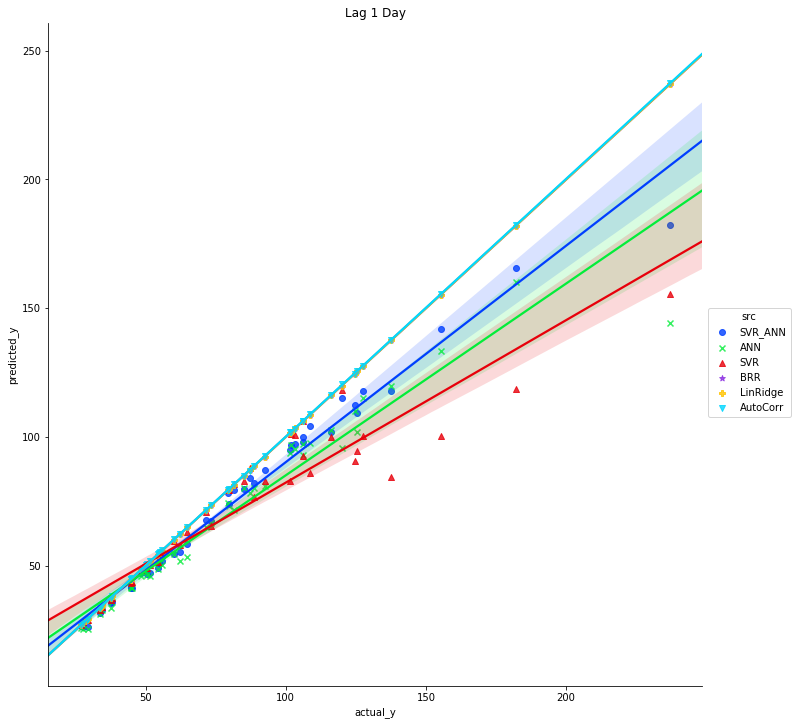

In [87]:
g = sns.lmplot(x="actual_y", y="predicted_y", hue="src", 
               data=concat_df, size=10, aspect=1, 
               markers=["o", "x", "^", "*", "P", "v"], palette=sns.color_palette('bright'))
ax = plt.gca()
ax.set_title("Lag 1 Day")

Text(0.5,1,'Lag 1 Day')

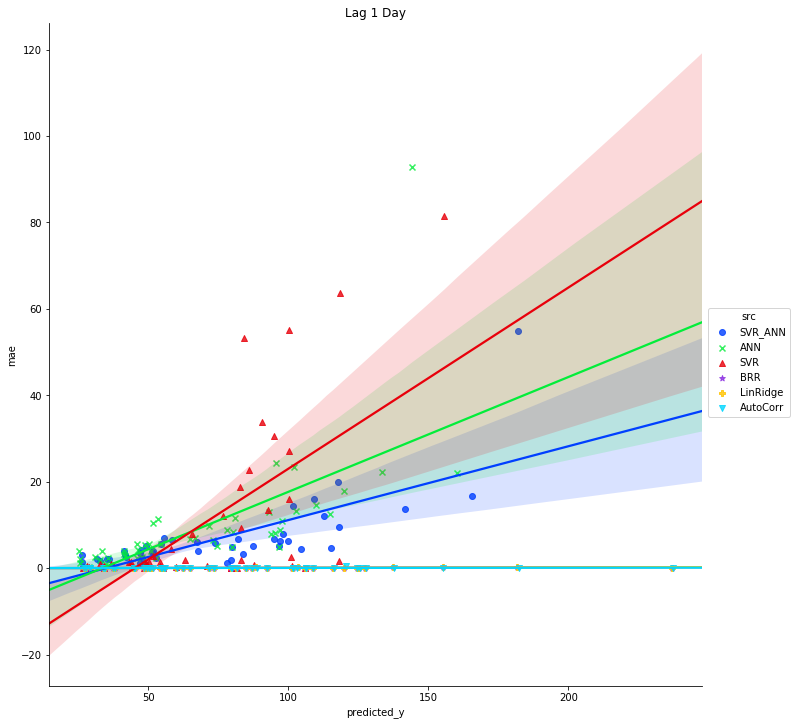

In [88]:
g = sns.lmplot(x="predicted_y", y="mae", hue="src", 
               data=concat_df, size=10, aspect=1, 
               markers=["o", "x", "^", "*", "P", "v"], 
               palette=sns.color_palette('bright'))
ax = plt.gca()
ax.set_title("Lag 1 Day")

Text(0.5,1,'Lag 7 Day')

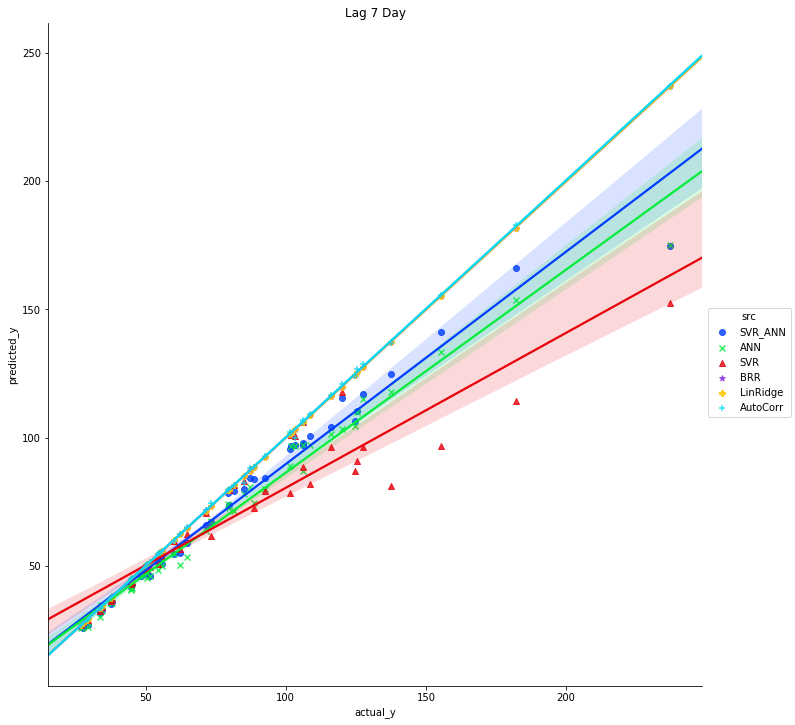

In [89]:
g = sns.lmplot(x="actual_y", y="predicted_y", hue="src", 
               data=concat_df7, size=10, aspect=1, 
               markers=["o", "x", "^", "*", "P", "+"], palette=sns.color_palette('bright'))
ax = plt.gca()
ax.set_title("Lag 7 Day")

Text(0.5,1,'Lag 7 Day')

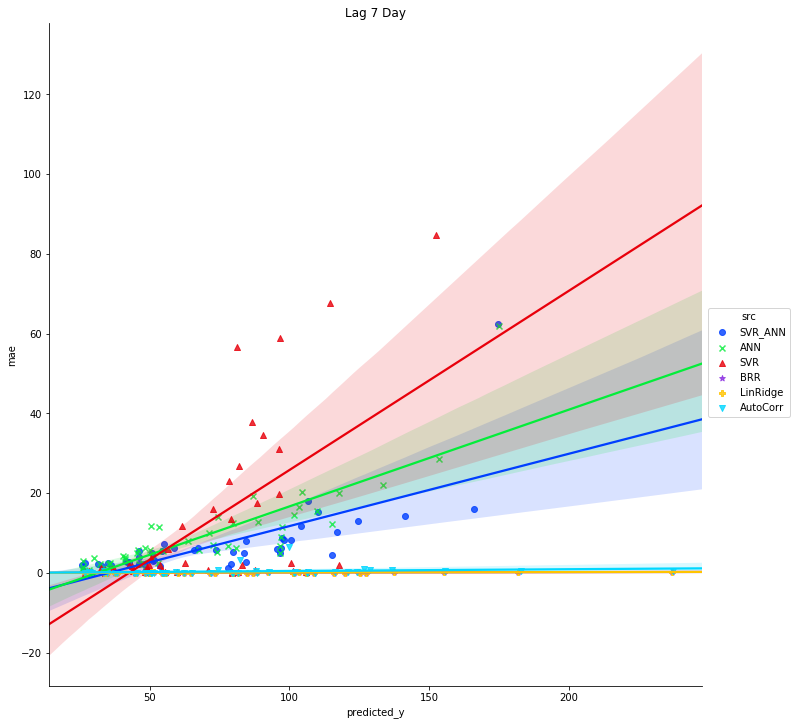

In [90]:
g = sns.lmplot(x="predicted_y", y="mae", hue="src", 
               data=concat_df7, size=10, aspect=1, 
               markers=["o", "x", "^","*", "P", "v"], palette=sns.color_palette('bright'))
ax = plt.gca()
ax.set_title("Lag 7 Day")

In [81]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 11, 9
# import statsmodels.api as sm
# seasonal_decomposition = sm.tsa.seasonal_decompose(data[data["etf"]=='aoa']["Close"],freq=365) # The frequncy is annual
# figure = seasonal_decomposition.plot()
# plt.show()

In [82]:
# def datetime_converter(new_data, etf):
#     beg_date = new_data[new_data['etf']==etf]["Date"].head(1).iloc[0]
#     beg_date = datetime(int(beg_date.split('-')[0]), int(beg_date.split('-')[1]), int(beg_date.split('-')[2]))
#     end_date = new_data[new_data['etf']==etf]["Date"].tail(1).iloc[0]
#     end_date = datetime(int(end_date.split('-')[0]), int(end_date.split('-')[1]), int(end_date.split('-')[2]))
#     return beg_date, end_date

In [83]:
# from datetime import datetime
# from collections import namedtuple
# Range = namedtuple('Range', ['start', 'end'])

# start, end=datetime_converter(new_data, 'voo')
# r1 = Range(start, end)

# start, end=datetime_converter(new_data, 'aoa')
# r2 = Range(start, end)

# latest_start = max(r1.start, r2.start)
# earliest_end = min(r1.end, r2.end)
# delta = (earliest_end - latest_start).days + 1
# overlap = max(0, delta)
# overlap